# Dissecting a GPT model

<a href="https://colab.research.google.com/drive/1x2QR2ftHlXCFectD7jkYU3F9NfnL2Piw" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

Return to the [Castle](https://github.com/Nkluge-correa/teeny-tiny_castle)

In this notebook, we will explore how a GPT-2 (Generative Pre-trained Transformer 2) model works. This walkthrough is based on the two-video series created by [Neel Nanda](https://www.neelnanda.io/) and serves as a great introduction to how GPT-style models work and the field of [mechanistic interpretability](https://www.neelnanda.io/mechanistic-interpretability/getting-started).

- [What is a Transformer? (Transformer Walkthrough Part 1/2)](https://www.youtube.com/watch?v=bOYE6E8JrtU).
- [Implementing GPT-2 From Scratch (Transformer Walkthrough Part 2/2)](https://www.youtube.com/watch?v=dsjUDacBw8o).

For other resources related to building and interpreting transformer models, check these other tutorials:

- [Building the original transformer architecture for sequence-to-sequence translation](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/master/ML%20Intro%20Course/16_sequence_to_sequence.ipynb)
- [Building a miniGPT model to generate text](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/master/ML%20Intro%20Course/17_text_generation.ipynb).
- [Interpret BERT models via integrated gradients](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/master/ML%20Explainability/NLP%20Interpreter/gradient_explanations_BERT.ipynb).

This implementation uses many utilities from the [`TransformerLens`](https://github.com/neelnanda-io/TransformerLens) library, so we will install some prerequisites before running anything.

In [1]:
# library for doing mechanistic interpretability of GPT-2 Style language models
!pip install git+https://github.com/neelnanda-io/TransformerLens -q

  Cloning https://github.com/neelnanda-io/TransformerLens to /tmp/pip-req-build-v8j0p8oa
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens /tmp/pip-req-build-v8j0p8oa
  Resolved https://github.com/neelnanda-io/TransformerLens to commit 1d8b1d8253f7009827ae89c7312465059f029499
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s

Before implementing anything, we need a GPT model to work with. Let us load a small version of GPT-2 (117M) so we can gain some understanding of what process this model performs during a forward pass.

In [2]:
import torch
from transformer_lens import HookedTransformer

gpt2 = HookedTransformer.from_pretrained("gpt2-small",
                                        fold_ln=False,
                                        center_unembed=False,
                                        center_writing_weights=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

display(gpt2, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_re

device(type='cpu')

GPT-2 is a _decoder-only transformer._

A `decoder-only` transformer is a type of transformer architecture that only contains the decoder part of the transformer model without the encoder part. In a [typical transformer architecture](https://arxiv.org/abs/1706.03762), the encoder processes an input sequence and generates a representation of that sequence in the form of a hidden/latent state. The decoder then takes this representation and generates an output based on it.

A decoder-only transformer takes a fixed-length vector (usually called a "_context vector_") as input and generates an output sequence based on it. In a `decoder-only` transformer, this context is the prompt we feed our model. In other words, if you feed in a sentence, the model will generate a probability distribution over tokens, and you can repeatedly sample from this to generate text.

Formally, you feed in a sequence of length $N$, then sample from the probability distribution over the $N+1-th$ word, use this to construct a new sequence of length $N+1$, then feed this new sequence into the model to get a probability distribution over the $N+2-th$ word, and so on.

$$sample_t = The \rightarrow_{model} The\;cat$$
$$sample_{t+1} = The\;cat \rightarrow_{model} The\;cat\;sat$$
$$sample_{t+2} = The\;cat\;sat \rightarrow_{model} The\;cat\;sat\;on$$
$$sample_{t+3} = The\;cat\;sat\;on \rightarrow_{model} The\;cat\;sat\;on\;the$$
$$sample_{t+4} = The\;cat\;sat\;on\;the \rightarrow_{model} The\;cat\;sat\;on\;the\;floor.$$

A decoder-only transformer like GPT-2 is trained on a large corpus of text data using a `causal language modeling` objective.

> Causal language modeling is a type of language modeling where a model is trained to predict the next word in a sequence given the previous words, with the constraint that the model can only use information from the past, not the future. More precisely, we only allow the model to perform attention on the left side of the sentence. Thus, the prediction of what comes after token $5$ is only a function of the first $5$ tokens, not of token $6$. This is why we call such models autoregressive (they predict the future only using past information). Their objective during training is to predict the next token in a sequence given the previous tokens.

<img src="https://jalammar.github.io/images/xlnet/gpt-2-autoregression-2.gif" width="600"/>

Source: [The Illustrated GPT-2 (Visualizing Transformer Language Models)](https://jalammar.github.io/illustrated-gpt2/).

Transformers are _sequence modeling engines_ that depend on a lot of linear algebra. They are (basically) a stack of `[linear + non-linear + linear]` operations, enclosed in blocks (`block = [attention, MLP, linear mapping]`), that read and write in a continuous stream of residual information.

<img src="https://imgs.xkcd.com/comics/machine_learning_2x.png" width="400"/>

Source: [xkcd](https://xkcd.com/1838/).

But they need something friendly to perform linear algebra on. Not words, but `vectors`. How do we turn words into vectors? We `tokenize` the words and pass them by an `embedding layer`.

To learn more about embedding layers:

- [Check this tutorial on how to work with embedding layers and perform basic interpretability analysis](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/master/ML%20Explainability/NLP%20Interpreter/investigating_word_embeddings.ipynb).
- [Check this tutorial on how to train a word2vec model](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/master/ML%20Explainability/NLP%20Interpreter/word2vec.ipynb).

All the other transformer models we trained in this repository use a tokenization scheme that creates a vocabulary of words (like a dictionary). However, the lack of punctuation and many useful symbols present in natural language make this tokenization scheme brittle. GPT-2, and many other large language models, use a tokenization scheme called `Byte-Pair` encodings, which allows the model to tokenize "chunks" of words by their 256 ASCII combinations, where common pairs of tokens are merged into a new single token. For example, the word "the," comprised of the ASCII characters `116 104 101`, quickly becomes a singular token in this schema since the word "the" always appears in English.

The GPT-2 tokenizer has a vocabulary formed out of 50257 tokens corresponding to words, chunks of words, symbols, numbers, etc. Let us see some of these tokens.

In [3]:
# number of parameters in gpt2
print("Number of parameters in the reference model: ", sum(p.numel() for p in gpt2.parameters()))

# numebr of tokens in gpt2 tokenizer
print("Number of tokens in the reference model tokenizer: ", len(list(gpt2.tokenizer.vocab.items())))

sorted_tokens = sorted(list(gpt2.tokenizer.vocab.items()), key=lambda n:n[1])

# display tokens 257 to 267
display(sorted_tokens[257:267])

# display last 10 tokens
display(sorted_tokens[-10:])

Number of parameters in the reference model:  163087441
Number of tokens in the reference model tokenizer:  50257


[('Ġa', 257),
 ('he', 258),
 ('in', 259),
 ('re', 260),
 ('on', 261),
 ('Ġthe', 262),
 ('er', 263),
 ('Ġs', 264),
 ('at', 265),
 ('Ġw', 266)]

[('Ġ(/', 50247),
 ('âĢ¦."', 50248),
 ('Compar', 50249),
 ('Ġamplification', 50250),
 ('ominated', 50251),
 ('Ġregress', 50252),
 ('ĠCollider', 50253),
 ('Ġinformants', 50254),
 ('Ġgazed', 50255),
 ('<|endoftext|>', 50256)]

Tokens that start with the letter `Ġ` represent that this token starts with a space. That means that "and" and " and" are different tokens. Many tokens are weird, and explaining "why" the tokenizer chooses to add the token " gazed" as a singular token is hard. But it did. The only explanation is that these are the most common bite pairs found in the training corpus.

You can use the `to_tokens` and `to_str_tokens` method from the `transformer_lens` library to explore how words are tokenized. You will see that spaces and capitalization matters in tokenization.

> Note: `prepend_bos=False` prevents the `bos` token (beginning of the sentence token = 50256) from being appended at every sentence's beginning.

In [4]:
# many types of cats
print(gpt2.to_str_tokens("Cat", prepend_bos=False))
print("'Cat' = token ", gpt2.to_tokens("Cat", prepend_bos=False)[0][0].cpu().numpy())
print(gpt2.to_str_tokens(" Cat", prepend_bos=False))
print("' Cat' = token ", gpt2.to_tokens(" Cat", prepend_bos=False)[0][0].cpu().numpy())
print(gpt2.to_str_tokens(" cat", prepend_bos=False))
print("' cat' = token ", gpt2.to_tokens(" cat", prepend_bos=False)[0][0].cpu().numpy())
print(gpt2.to_str_tokens("cat", prepend_bos=False))
print("'cat' = token ", gpt2.to_tokens("cat", prepend_bos=False)[0][0].cpu().numpy())

# and much more crazy stuff
print("'8248247+939-100/70' = ",gpt2.to_str_tokens("8248247+939-100/70", prepend_bos=False))

['Cat']
'Cat' = token  21979
[' Cat']
' Cat' = token  5181
[' cat']
' cat' = token  3797
['cat']
'cat' = token  9246
'8248247+939-100/70' =  ['8', '248', '247', '+', '9', '39', '-', '100', '/', '70']


The tokenizer is a look-up table that turns words and sub-words into integers. These integers are then turned into vectors by an embedding layer. This embedding layer is also a kind of look-up table, where each token in our vocabulary corresponds to a specific vector representation of dimensionality equal to the dimensionality of the embedding layer. GPT-2 works with $d_{embeddings} = 768$, and the ouput of embedding layer is shape $[d_{batch}, d_{length}, d_{dimensionality}]$.

In [5]:
sentence = "The cat sat on the"
print("Sentence: ", sentence)

# convert the sentence to tokens
sentence_tokens = gpt2.to_tokens(sentence, prepend_bos=False)
print("Tokenized Sentence: ", sentence_tokens)

# convert the tokens back to sentence
string_tokens = gpt2.to_str_tokens(sentence, prepend_bos=False)
print("String Tokens: ", string_tokens)

# convert the tokenks to embedding vectors
sentence_embed = gpt2.embed(sentence_tokens)
print("Sentence Embedding Shape: ", sentence_embed.shape)

Sentence:  The cat sat on the
Tokenized Sentence:  tensor([[ 464, 3797, 3332,  319,  262]])
String Tokens:  ['The', ' cat', ' sat', ' on', ' the']
Sentence Embedding Shape:  torch.Size([1, 5, 768])


Given this input, the goal of the model is to output a probability distribution over the next tokens for every prefix of the sequence (a $7$ token sequence generates $7$ next token predictions).

The initial embedding matrix is passed by a series of transformer layers (GPT-2 small has 12 layers), which are made of multi-head attention layers and MLP layers (plus some normalization and skip connections). The final output of this process is a vector of logits, i.e.,  a vector of unnormalized scores over the vocabulary (50257 tokens).

This vector is then normalized using a softmax function that turns the logits into a probability distribution (a positive distribution that sums up to 1):

$$softmax(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$$

If we want to sample from this distribution greedily, we select the next token as the one with the highest probability score.


In [6]:
# pytorch forces us to declare the device on which we want to perform the operations
sentence_tokens = sentence_tokens.to(device)

# pass the sentence through gpt2
logits, cache = gpt2.run_with_cache(sentence_tokens)

# print the logits shape (batch_size, sequence_length, vocab_size)
print("Logits Shape",logits.shape)

# perform softmax on the logits to get the probabilities
probs = torch.nn.functional.softmax(logits,dim=-1)

# print the probabilities shape (batch_size, sequence_length, vocab_size)
print("Softmax Output", probs.shape)

Logits Shape torch.Size([1, 5, 50257])
Softmax Output torch.Size([1, 5, 50257])


We can see now that the model generated a `next_token_prediction` for every token in the seed sentence.

In [7]:
for i in range(probs.shape[1]):
    print("Current token: ", string_tokens[i])
    print("Probability: ", probs[0][i].max().item())
    print("Next token with max probability: ", sorted_tokens[probs[0][i].argmax().item()])
    print("")

Current token:  The
Probability:  0.013599203899502754
Next token with max probability:  ('Ċ', 198)

Current token:   cat
Probability:  0.11036118119955063
Next token with max probability:  ('Ġwas', 373)

Current token:   sat
Probability:  0.22397193312644958
Next token with max probability:  ('Ġon', 319)

Current token:   on
Probability:  0.4537064731121063
Next token with max probability:  ('Ġthe', 262)

Current token:   the
Probability:  0.0763581395149231
Next token with max probability:  ('Ġfloor', 4314)



Let us see what "_other things_" our cat could have seated on according to GPT-2 by sampling the first $k$ most likely next tokens for the final token in our seed sentence.

In [8]:
# get the top k values and their corresponding indices
topk_values, topk_indices = torch.topk(probs[0][-1], k=5)

# print the top k values and their corresponding indices
for i in range(topk_values.shape[0]):
    print(f"Next token (top {i+1}): ", sorted_tokens[topk_indices[i].item()])
    print("Probability: ", topk_values[i].item())
    print("")

Next token (top 1):  ('Ġfloor', 4314)
Probability:  0.0763581395149231

Next token (top 2):  ('Ġbed', 3996)
Probability:  0.06527771055698395

Next token (top 3):  ('Ġcouch', 18507)
Probability:  0.0540725439786911

Next token (top 4):  ('Ġground', 2323)
Probability:  0.052090004086494446

Next token (top 5):  ('Ġedge', 5743)
Probability:  0.04784207046031952



In [9]:
sentence = "The cat sat on the"
print("Sentence at t: ", sentence)

sentence_tokens = gpt2.to_tokens(sentence, prepend_bos=False).to(device)

for i in range(10):

    # pass the sentence through the reference model and get the logits
    logits = gpt2(sentence_tokens)

    # perform softmax on the logits to get the probabilities
    probs = torch.nn.functional.softmax(logits,dim=-1)

    # get the next token
    next_token = probs[0, -1].argmax(dim=-1)

    # append the next token to the sentence
    sentence_tokens = torch.cat([sentence_tokens, next_token[None, None]], dim=-1)

    # convert the next token to string
    next_char = gpt2.to_string(next_token)

    # append the next token to the sentence
    sentence = sentence + next_char

    print(f"Sentence at t + {i+1}: ", sentence)


Sentence at t:  The cat sat on the
Sentence at t + 1:  The cat sat on the floor
Sentence at t + 2:  The cat sat on the floor,
Sentence at t + 3:  The cat sat on the floor, and
Sentence at t + 4:  The cat sat on the floor, and the
Sentence at t + 5:  The cat sat on the floor, and the cat
Sentence at t + 6:  The cat sat on the floor, and the cat was
Sentence at t + 7:  The cat sat on the floor, and the cat was still
Sentence at t + 8:  The cat sat on the floor, and the cat was still asleep
Sentence at t + 9:  The cat sat on the floor, and the cat was still asleep.
Sentence at t + 10:  The cat sat on the floor, and the cat was still asleep.



Now we know:

1. What are decoder-only transformers, and what is their main function (_sequence modeling_).
2. How transformers encode language via tokenization.
3. How tokens are converted into embeddings. Embeddings are a matrix/look-up table of shape $[d_{dimensionality}, d_{vocabulary}]$
4. The output of the embedding layer is of shape $[d_{batch}, d_{length}, d_{dimensionality}]$
4. That a GPT-style model is built of decoder blocks. Every block has a Multihead attention layer and an MLP layer combined (plus some extra stuff).
5. Decoder-only transformers are trained via causal language modeling (they can only look at the past).
6. They output a prediction for every prefix in their input sequence.
7. These predictions are the final output of the model. A vector of logits that can be normalized (via softmax) into a probability distribution over $d_{vocabulary}$ of the model.
7. Sampling from this distribution in an iterated fashion allows us to generate text.

Let us take a look into what happens inside the decoder blocks of a GPT-style model.

> Note: this explanation is based on the article "_[A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html)_", by [Anthropic](https://www.anthropic.com/).

The transformer architecture can be taught at a high level as a sequence of transformer layers. Each layer has a fixed number of `attention heads` ($h_1$, $h_2$,...$h_n$) that are concatenated into a multi-head attention layer ($H_k$). Each layer has a multi-head attention layer and an MLP (multi-layer perceptron, $M_k$) ($Layer_k = (H_k, M_k)$), with each one performing operations on the residual stream. This residual stream is the central object of the transformer. The residual stream has a constant shape $[d_{batch}, d_{length}, d_{dimensionality}]$.

Each one of the blocks in a transformer can be represented by the diagram below.

> Note: Tokenization + Embedding (and positional embedding) only happen before the first transformer block. `Positional embedding` is an extra embedding layer used to give positional information to the sequence. We can input temporal information into our sequence since attention is permutation invariant and position agnostic. Positional information helps the model figure out that words are close to each other, which usually implies that they are relevant to each other.

<img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure_W640.jpg" width="200"/>

Source: [Multi-lingual Intent Detection and Slot Filling in a Joint BERT-based Model](https://www.researchgate.net/publication/334288604_Multi-lingual_Intent_Detection_and_Slot_Filling_in_a_Joint_BERT-based_Model).

Thus:

1. The incomming residual stream ($[d_{batch}, d_{length}, d_{dimensionality}]$) passes by the MultiHead attention layer.
2. Each attention head performs self-attention on the input in parallel, adding their results to the output.
3. This output is then normalized by a layer norm.
4. The MLP layer passes the normalized output.
5. The output of the MLP layer is added to the output of the MultiHead attention layer, normalized, and passed through the next layer in the original shape of the residual stream ($[d_{batch}, d_{length}, d_{dimensionality}]$).
6. Both the MLP and MultiHead attention layers read and write to the residual stream.

We already talked about tokenization and embedding, so let us talk about Attention, MLP, and Layernorm.

Attention (we are referring to self-attention) moves information from prior positions in the sequence to the current token. The word "sat" should be strongly tied to "cat" in our example sentence, and attention carries this information from token-to-token. Attention layers are the only bit of a transformer that moves information between positions. Attention heads act independently and additively, adding their outputs to the stream. This process is linear (addition and multiplication).

Attention has three significant components:

- Query: The query is a representation of the current token used to score against all the other tokens (_what we have at our current position_).
- Key: Key vectors are what we match our query against (_what does the sequence have to offer_).
- Value: Value vectors are actual word representations (like the word embeddings before the first attention block), we add the attention scores to each of these values to create a new representation of the current word (_what should you pay attention to at the end_).

But the general "_gist_" of attention is this:

Given our three input matrices: the query matrix ($Q$), the key matrix ($K$), and the value matrix ($V$), we compute a weighted sum of the value matrix ($V$) based on the similarity between the queries ($Q$) and the keys ($K$).

The query, key, and value matrices are typically derived from the input data by applying a linear transformation to the input features. The dimensions of the matrices depend on the input size and the number of attention heads the model uses.

First, we compute the dot product of the query and key matrices, which produce a matrix of dot products. The dot products are then divided by the square root of the dimensionality of the key matrix to ensure that the attention weights are under the same scale. Finally, the dot products are passed through a softmax function to produce a matrix of attention weights that sum to $1$.

The attention weights are then used to weight the value matrix ($V$) and compute a weighted sum of the values, which is then used as the output of the attention head. This process is repeated for each attention head, and the output of all the attention heads is concatenated to produce the final output.

$$ Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V $$

Where:
- $Q$ is the query matrix.
- $K$ is the key matrix.
- $V$ is the value matrix.
- $d_k$ is the dimensionality of the key matrix.

The MLP layers are just a standard neural network, with a singular hidden layer and a nonlinear activation function (usually [`GELU`](https://paperswithcode.com/method/gelu#:~:text=The%20Gaussian%20Error%20Linear%20Unit,x%201%20x%20%3E%200%20)). They are followed by a linear mapping layer that projects the output of the MLP back to the dimensionality of the residual stream (MLPs usually have a higher dimensionality than that of the residual stream) ($linear\;map \rightarrow non-linearity \rightarrow linear\;map$).

The general intuition behind the MultiHead attention/MLP/linear projection sandwich is that after attention has moved relevant information to a single position in the residual stream, MLPs perform computation on the stream.

This process is repeated until the last layer, where the residual stream is finally projected into a vector of logits representing the model's confidence distribution for next token predictions over $d_{vocabulary}$.

Layernorm is the normalization applied at the start of each layer (MLP, MultiHead attention, and before the unembedding) to convert each input vector to mean zero and variance 1.

`Activations` are temporary numbers calculated during a forward pass that are input functions. Attention scores and patterns are examples of activations. The residual stream can be thought of as one flowing stream of activations.

> Note: the `run_with_cache` method (from `transformer_lens`) allows us to store all information associated with a forward pass in a transformer model, which is quite useful for interpretability research. With it, we can access all matrices that compose the transformer network and monitor the residual stream (the residual flow of information that travels through the forward pass) as it progresses.

In [10]:
# names and shapes of the activation in the first layer of the reference model
for activation_name, activation in cache.items():
    if ".0." in activation_name or "blocks" not in activation_name:
        print(f"{activation_name:30} {tuple(activation.shape)}")

hook_embed                     (1, 5, 768)
hook_pos_embed                 (1, 5, 768)
blocks.0.hook_resid_pre        (1, 5, 768)
blocks.0.ln1.hook_scale        (1, 5, 1)
blocks.0.ln1.hook_normalized   (1, 5, 768)
blocks.0.attn.hook_q           (1, 5, 12, 64)
blocks.0.attn.hook_k           (1, 5, 12, 64)
blocks.0.attn.hook_v           (1, 5, 12, 64)
blocks.0.attn.hook_attn_scores (1, 12, 5, 5)
blocks.0.attn.hook_pattern     (1, 12, 5, 5)
blocks.0.attn.hook_z           (1, 5, 12, 64)
blocks.0.hook_attn_out         (1, 5, 768)
blocks.0.hook_resid_mid        (1, 5, 768)
blocks.0.ln2.hook_scale        (1, 5, 1)
blocks.0.ln2.hook_normalized   (1, 5, 768)
blocks.0.mlp.hook_pre          (1, 5, 3072)
blocks.0.mlp.hook_post         (1, 5, 3072)
blocks.0.hook_mlp_out          (1, 5, 768)
blocks.0.hook_resid_post       (1, 5, 768)
ln_final.hook_scale            (1, 5, 1)
ln_final.hook_normalized       (1, 5, 768)


`Parameters` are the weights and biases that the model learned during training. These values do not change when the input changes. They are, for example, the weights (connections) in the MLP layers, or the values in the embedding layer.

In [11]:
# names and shapes of the parameters in the first layer of the reference model
for name, param in gpt2.named_parameters():
    if ".0." in name or "blocks" not in name:
        print(f"{name:18} {tuple(param.shape)}")

embed.W_E          (50257, 768)
pos_embed.W_pos    (1024, 768)
blocks.0.ln1.w     (768,)
blocks.0.ln1.b     (768,)
blocks.0.ln2.w     (768,)
blocks.0.ln2.b     (768,)
blocks.0.attn.W_Q  (12, 768, 64)
blocks.0.attn.W_O  (12, 64, 768)
blocks.0.attn.b_Q  (12, 64)
blocks.0.attn.b_O  (768,)
blocks.0.attn.W_K  (12, 768, 64)
blocks.0.attn.W_V  (12, 768, 64)
blocks.0.attn.b_K  (12, 64)
blocks.0.attn.b_V  (12, 64)
blocks.0.mlp.W_in  (768, 3072)
blocks.0.mlp.b_in  (3072,)
blocks.0.mlp.W_out (3072, 768)
blocks.0.mlp.b_out (768,)
ln_final.w         (768,)
ln_final.b         (768,)
unembed.W_U        (768, 50257)
unembed.b_U        (50257,)


One of the central focuses on interpretability in transformer models is the inner workings of how activations change concerning an input, and one of the main activations of interest in transformers is attention maps.

> Note: attention maps are a scalar matrix representing the relative importance of tokens assigned by the layer activations at different 2D spatial locations concerning the given attention head.  

GPT-2 small has 12 layers, and every layer has 12 attention heads working in parallel and individually. `TransformerLens` gives access, via the run_with_cache method, in a very straightforward way to these activations, so we can pass them through any visualization library to plot our attention maps.

In [12]:
sentence_tokens=gpt2.to_str_tokens(sentence, prepend_bos=False)

tokens = gpt2.to_tokens(sentence, prepend_bos=False)
tokens = tokens.to(device)

_, cache = gpt2.run_with_cache(tokens)

for i in range(len([x for x in cache.keys() if "pattern" in x])):
    print(f"Layer {i+1} has {cache['pattern', i][0].shape[0]} heads. Each outputs a pattern of shape {cache['pattern', i][0].shape[1:]}")

Layer 1 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])
Layer 2 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])
Layer 3 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])
Layer 4 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])
Layer 5 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])
Layer 6 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])
Layer 7 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])
Layer 8 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])
Layer 9 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])
Layer 10 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])
Layer 11 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])
Layer 12 has 12 heads. Each outputs a pattern of shape torch.Size([15, 15])


You can do this using `matplotlib`.

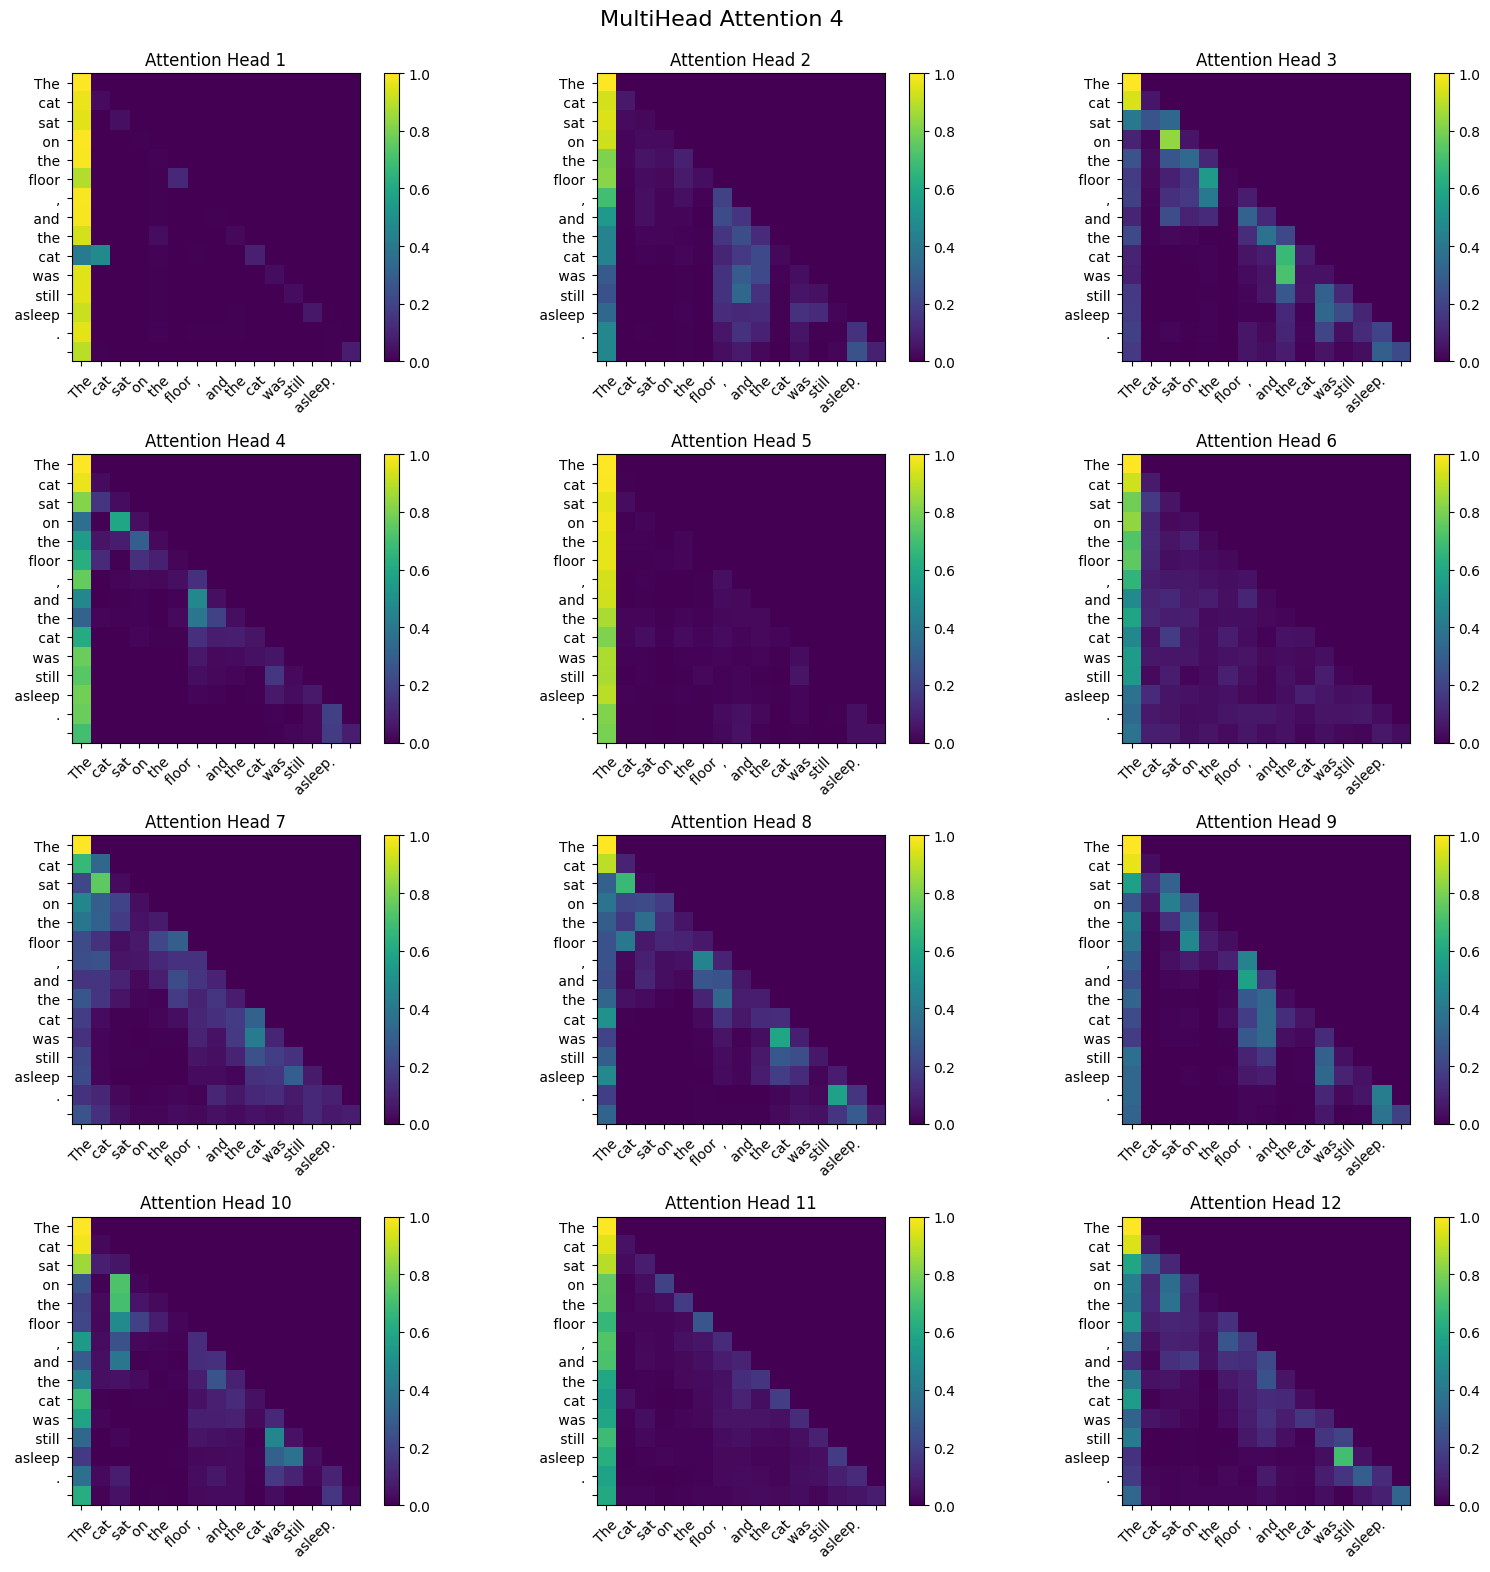

In [13]:
layer = 3 # choose the layer from 0 to 11

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(cache["pattern", layer][0][i].cpu().numpy(), cmap='viridis')
    ax.set_title('Attention Head {}'.format(i+1))

    ax.xaxis.set_ticks(range(len(sentence_tokens)))
    ax.yaxis.set_ticks(range(len(sentence_tokens)))
    ax.set_xticklabels(sentence_tokens)
    ax.set_yticklabels(sentence_tokens)
    ax.tick_params(axis='x', which='major', pad=5, rotation=45)
    ax.tick_params(axis='y', which='major', pad=5)
    plt.colorbar(im, ax=ax)

fig.suptitle(f'MultiHead Attention {layer + 1}', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.show()

Or something like `Plotly`.

In [14]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


fig = go.Figure()
specs = [[{'type': 'heatmap'}]*3]*4
subplot_titles = [f"Attention Head {i+1}" for i in range(12)]
fig = make_subplots(rows=4, cols=3, specs=specs, subplot_titles=subplot_titles)

for i in range(1, 13):
    row = (i - 1) // 3 + 1
    col = i % 3 if i % 3 != 0 else 3
    fig.add_trace(
        # plotly go.Heatmap requires the matrix to be flipped
        go.Heatmap(z=cache["pattern", layer][0][i-1].cpu().numpy()[::-1, :],
            texttemplate="%{z}",
            showscale=False,
            hovertemplate='Key: %{x}<br>Query: %{y}<br>Attention Score: %{z}<extra></extra>'),
            row=row, col=col)

    fig.update_xaxes(title_text="Key", ticktext=sentence_tokens,row=row, col=col, tickmode='array',
                    tickvals=list(range(len(sentence_tokens))), tickangle=45)
    fig.update_yaxes(title_text="Query", ticktext=sentence_tokens[::-1],row=row, col=col, tickmode='array',
                    tickvals=list(range(len(sentence_tokens))))
    fig.update_layout(template="plotly_dark",
                        title_text=f"<b><i>MultiHead Attention - Layer {layer + 1}</i></b>",
                        font=dict(size=10),
                        height=1300,
                        paper_bgcolor='rgba(0, 0, 0, 0)',
                        plot_bgcolor='rgba(0, 0, 0, 0)',
                        )

fig.show()

These attention maps represent the relative importance of different tokens in the input sequence with respect to each other. A higher attention score between two tokens indicates that they are more relevant to each other. All attention head contributes to the final MultiHead Attention output. This output will be written to the residual stream together with the output of the MLP layer.

One way to interpret these maps is by looking at how the queries are scored against each key. For example, at layer 12, head 11, the query "_floor_" focuses most on "_sat_." This pattern emerges again in heads 9 and 4, where most of the attention associated with the query "_floor_" is again paid to the value "_sat_." These heads independently agree that "_sat_" and "_floor_" are correlated in this context. These maps also help us visualize what `causal masking` is, wich is zeroing all the right-upper side of our attention matrix (queries cannot look to the keys in the future).

Attention represents a vital part of transformer and GPT-style architectures, and understanding how attention heads coordinate, even in different layers, to help enrich the context of the residual stream is an open problem in interpretability research.

Another point of interest is what happens inside the MLP layers, but this we will leave for another tutorial.

---

Return to the [Castle](https://github.com/Nkluge-correa/teeny-tiny_castle)